In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import math
import scipy
from collections import Counter
import copy
%matplotlib inline

## Часть 1

Приблизим процесс следующим образом: 

$X_t = \frac{\xi_0 t }{\sqrt{\pi}} + \sqrt{\frac{2}{\pi}} {\sum_{n=1}^{precision}} \frac{\sin(kt)}{k} \xi_k$ , где 
$\xi_k \sim N(0,1) , t \in [0, \pi]$.

Продолжим на $\mathbb{R} +$ как  $X_t = \sqrt{\pi} \sum_{n=0}^{m-1}\xi_{0_n} + X_{t_2}$ , где $ \pi m \leq t < \pi (m+1)$ , $t_2 = t - \pi m $.


Я воспользуюсь двумя циклами. Один как np.vectorize для цикла по $t_i$, второй при распределении случайных величин по отрезкам генерации - он необходим,так как я разбил генерацию случйных величин и подсчет процесса на 2 разные операции, которые запускаются один раз для всех $t$. Это сделано для оптимизации, а именно для того, чтобы вызывать np.random только один раз для всех значений t_i из запроса.

In [104]:
class WinerProcess:
    def __init__(self,precision=10000):
        if precision == 0:
            precision = 1
        
        self.precision = precision
        self.eps = 1e-20
        self.ksi_0 = []
        self.ksi = dict()
        self.cumsum = []
        self._calc_X_vect = np.vectorize(self._calc_X)
        self._get_bound_vect = np.vectorize(self._get_bound)
    
#     returns k that time in [k*\pi; (k+1)*\pi]
    def _get_bound(self,time):
        return int(time/np.pi + self.eps)

    def _calc_X(self,t):
        k = self._get_bound(t)
        t -= np.pi * k
        i = np.arange(1,self.precision + 1)
        sin_all = np.sin(t * i)
        
        x = np.sum(self.ksi[k] * sin_all / i)
        x *= 2.0**0.5
        x += self.ksi_0[k] * t
        x /= (np.pi)**0.5
        if k > 0:
            x += (np.pi)**0.5 * self.cumsum[k-1]
        return x
    
    def _build_ksi(self,times):
        k = self._get_bound(np.max(times))
        if k >= len(self.ksi_0):
            self.ksi_0 = self.ksi_0 + list(np.random.normal(size=k - len(self.ksi_0) + 1))
            self.cumsum = np.cumsum(self.ksi_0)

        need_size = 0
#       build necessary ksi 
        k_unique = np.unique(self._get_bound_vect(times))
        need_size = sum(1 for k in k_unique if k not in self.ksi)
        new_ksi = np.random.normal(size=need_size*self.precision)
        #the second cyle
        for i in range(len(k_unique)):
            k = k_unique[i]
            if k not in self.ksi :
                self.ksi[k] = new_ksi[i*self.precision:(i+1)*self.precision]
    
    def __getitem__(self,times):
        self._build_ksi(times)
        return self._calc_X_vect(times) #the main cycle (legitimate)


In [93]:
def ln_law_bound(t):
    return np.sqrt((2* t * np.log(np.log(t+3))))
f = np.vectorize(ln_law_bound)

CPU times: user 33.8 ms, sys: 8 µs, total: 33.8 ms
Wall time: 33.8 ms
CPU times: user 37.6 ms, sys: 32 µs, total: 37.6 ms
Wall time: 37.6 ms
CPU times: user 33.7 ms, sys: 5 µs, total: 33.7 ms
Wall time: 33.7 ms
CPU times: user 48.3 ms, sys: 400 µs, total: 48.7 ms
Wall time: 49.1 ms
CPU times: user 47.4 ms, sys: 651 µs, total: 48.1 ms
Wall time: 48.8 ms
CPU times: user 49.2 ms, sys: 404 µs, total: 49.6 ms
Wall time: 50 ms
CPU times: user 52 ms, sys: 437 µs, total: 52.4 ms
Wall time: 52.7 ms
CPU times: user 48.4 ms, sys: 460 µs, total: 48.9 ms
Wall time: 49.5 ms
CPU times: user 57 ms, sys: 2.16 ms, total: 59.1 ms
Wall time: 63.9 ms
CPU times: user 54.7 ms, sys: 1.47 ms, total: 56.1 ms
Wall time: 60.5 ms


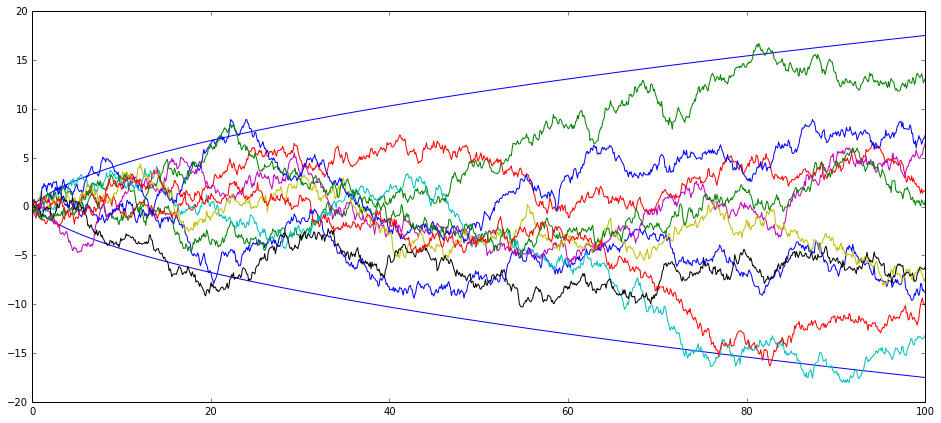

In [106]:
times = np.linspace(0,100,1000)
y2 = f(times)
plt.figure(figsize=(16,7))
plt.plot(times,y2,color='b')
plt.plot(times,-y2,color='b')

a = [WinerProcess(1000) for i in range(10)]
for i in np.arange(10):
    %time y = a[i][times]
    plt.plot(times,y)
plt.show()

In [107]:
Wt = WinerProcess(1000)
t = np.linspace(0, 1000, 1000)
%time values = Wt[t]

CPU times: user 62.2 ms, sys: 2.07 ms, total: 64.2 ms
Wall time: 65.1 ms


In [81]:
Wt = WinerProcess()
t = np.linspace(0, 10 ** 7, 10 ** 5)
%time values = Wt[t]

CPU times: user 1min 20s, sys: 22.1 s, total: 1min 43s
Wall time: 2min 47s


Код из задания работает 2 min 47s, что достаточно быстро, основное время тратится на вычисление синусов: 10\**9 вычислений, можно очень сильно оптимизировать вычисления, если сетка (times) равномерная.

Воспользуемся решенными теоретическими задачами:


$\sqrt{c}W_{\frac{t}{c}}$ также является винеровским процессом.

Возьмем $c = \frac{step}{\pi}$, тогда получим: $t'_i = i \pi$,  $W_t[t_i] = \sqrt{c} W_\frac{t}{c}[t_i] = \sqrt{c} 
W_t[\frac{t_i}{c}] = \sqrt{c} \sqrt{\pi} \sum_{n=0}^{i-1} \xi_n$ (рассматриваем 0-индексацию), т.к. все синусы обнулятся во всех значениях $t'_i$ , то получим нужную нам величину с почти неограниченной точностью.

In [153]:
def winer_process_path(end_time, step, precision=10000):
    times = np.arange(0,end_time,step)
    c = step/np.pi
    ksi = np.random.normal(size=len(times))
    ksi[0] = 0
    values = (c * np.pi)**0.5 * np.cumsum(ksi)
    return times , values

CPU times: user 25.6 ms, sys: 5.63 ms, total: 31.2 ms
Wall time: 32 ms
CPU times: user 27.4 ms, sys: 4.23 ms, total: 31.6 ms
Wall time: 32.1 ms
CPU times: user 28.5 ms, sys: 6.64 ms, total: 35.2 ms
Wall time: 36.1 ms
CPU times: user 26.8 ms, sys: 4.24 ms, total: 31.1 ms
Wall time: 32 ms
CPU times: user 25.2 ms, sys: 4.32 ms, total: 29.6 ms
Wall time: 31 ms


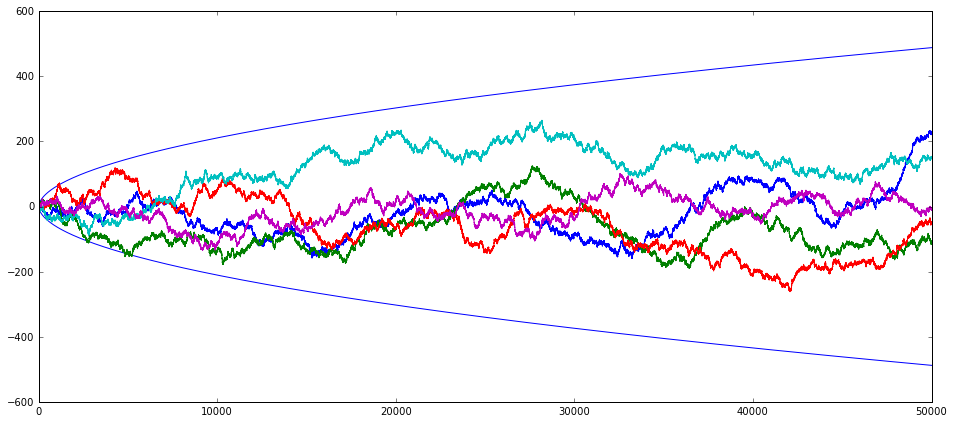

In [150]:
times = np.arange(0,50000,0.1)
y2 = f(times)
plt.figure(figsize=(16,7))
plt.plot(times,y2,color='b')
plt.plot(times,-y2,color='b')

for i in range(5):
    %time times,y = winer_process_path(50000, 0.1)
    plt.plot(times,y)
plt.show()

In [110]:
Wt = WinerProcess(100)

CPU times: user 1.22 s, sys: 14.2 ms, total: 1.23 s
Wall time: 1.25 s
CPU times: user 1.08 s, sys: 7.07 ms, total: 1.09 s
Wall time: 1.1 s
CPU times: user 1.07 s, sys: 3.62 ms, total: 1.07 s
Wall time: 1.07 s
CPU times: user 1.79 s, sys: 27.5 ms, total: 1.82 s
Wall time: 1.89 s
CPU times: user 1.26 s, sys: 6.59 ms, total: 1.27 s
Wall time: 1.27 s
CPU times: user 1.27 s, sys: 7.05 ms, total: 1.28 s
Wall time: 1.29 s
CPU times: user 3.81 s, sys: 27.4 ms, total: 3.84 s
Wall time: 3.89 s
CPU times: user 3.16 s, sys: 2.05 ms, total: 3.16 s
Wall time: 3.16 s
CPU times: user 3.14 s, sys: 2.26 ms, total: 3.15 s
Wall time: 3.15 s


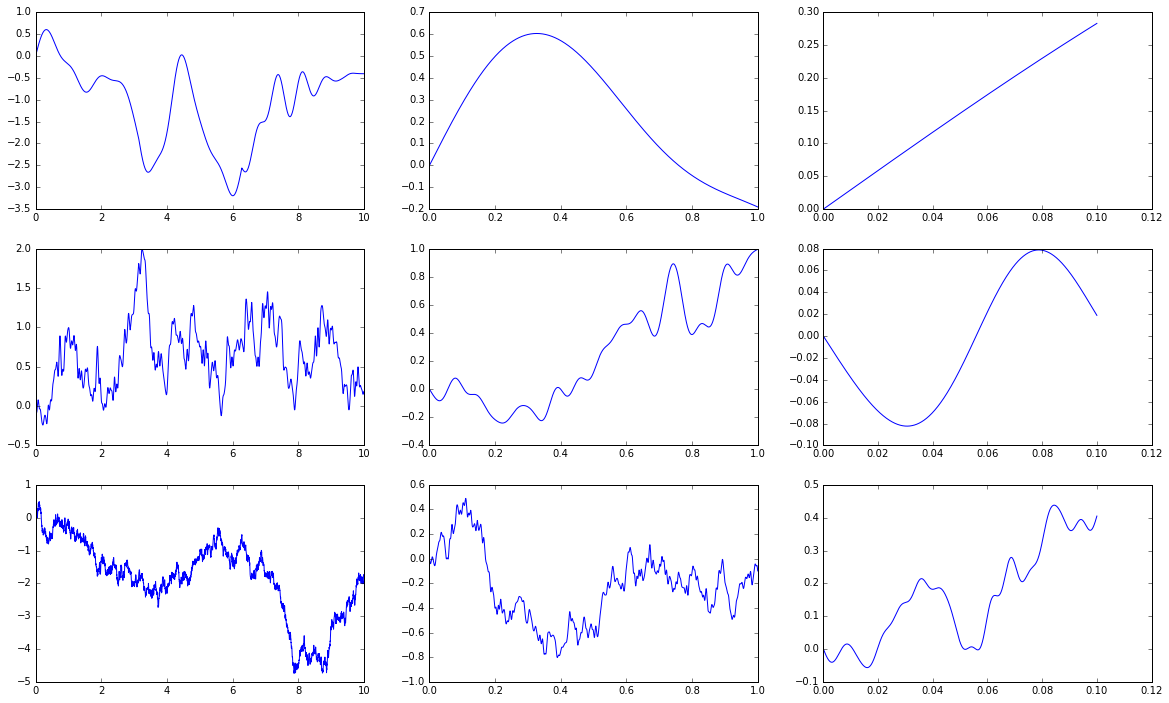

In [113]:
plt.figure(figsize=(20, 12)) 
n = [10,100,1000]
r_bound = [10,1,0.1]
for i in range(3):
    Wt = WinerProcess(n[i])
    for j in range(3):
        t = np.linspace(0, r_bound[j], 10 ** 5)
        %time values = Wt[t]
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.plot(t,values)
plt.show()


In [172]:
paths_from_files = []
k = 0
for k in range(10):
    fpath = 'data/winer_paths_' + str(k + 1) + '.txt'
    with open(fpath) as f_in:
        for line in f_in:
            s = line.split()
            paths_from_files.append([float(c) for c in s])
print(len(paths_from_files))
                    

100


## Часть 2
Проведем исследование 4

In [173]:
times = np.arange(0,50000,0.1)

In [174]:
paths = paths_from_files + [winer_process_path(50000, 0.1)[1] for i in range(100)]
print(len(paths))

200


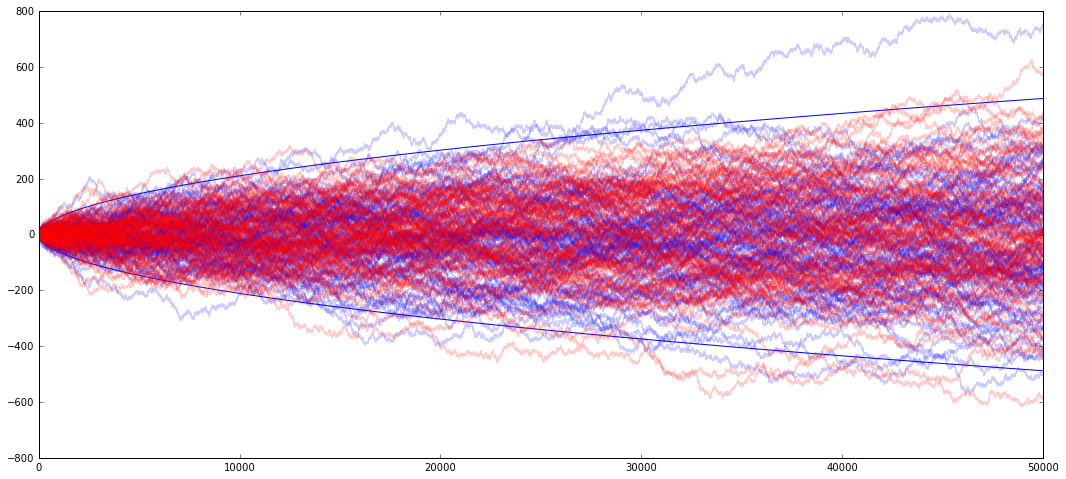

In [194]:
plt.figure(figsize=(18,8))
y2 = f(times)
plt.plot(times,y2,color='b')
plt.plot(times,-y2,color='b')
for i in range(200):
    color = 'blue'
    if(i >= 100):
        color = 'red'
    plt.plot(times,paths[i],color=color,alpha=0.2)
plt.show()

In [221]:
for x in paths:
    x = np.array(x)

Посчитаем для каждой траектории функцию $X(t) = \left|\{s:W_s = M, s\in [0,t] , M = max(W_s,s \leq t)\}\right|$ - количество максимумов на префиксе t траектории.

Даже с небольшей погрешностью $\varepsilon = 10^{-5}$

In [308]:
def get_argmax_size_all(proc):
    eps = 1e-5
    ans = np.zeros(len(proc),dtype=int)
    id_max = 0
    cur = 1
    ans[0] = 1
    for i in range(1,len(proc)):
        if abs(proc[i] - proc[id_max])< eps:
            cur += 1
        else : 
            if proc[i] > proc[id_max] :
                cur = 1
                id_max = i
        ans[i] = cur
    return ans

In [310]:
maximums_count = [get_argmax_size_all(p) for p in paths[0:10]]
print(maximums_count)

[array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1])]


In [312]:
# plt.figure(figsize=(10,5))
max_count = 0;
for y in maximums_count:
    max_count = max(max_count, np.max(y))
#     plt.plot(times,y,alpha=0.2)
# plt.show()
max_count

1

Как видим, для всех траекторий, для всех проверенных значений длины префикса t встречается только один максимум.

Заметим, что $X_t \geq 1$ по определению.

$P(X_t \geq 2) = 0$

Гипотеза: $X_t = 1 п.н. \forall t$

Заметим, что если $W_{t_1} = W_{\text{max}}$ , где $W_{max}$ - максимальное значение $W_t$ на $[0;t]$, то $t_1$ должна быть точкой локального максимума п.н. То есть $\exists \varepsilon > 0$ такое что $\forall t \in B_\varepsilon W_{t} < W_{t_1}$ , значит каждой точке максимума можно сопоставить рациональное число (для разных точек разные числа), значит таких максимумов не более чем счетно. Так для каждой точки локального максимума $s$ можно посчитать вероятность P_i существования другой точки $t > s$ локального максимума, такой что $W_t = W_s$:

$W_t = W_s \implies W_t - W_s = 0$  не зависит от $W_s$, $P(W_t - W_s = 0) = P(W_t - W_s = 0 | W_s = const) = 0$

но $P(X_t \geq 2) \leq \sum P_i = \sum 0 = 0$

т.е. $X_t = 0$ п.н.

тут еще есть проблема, что максимум может быть не строгим, наверное можно что-то сказать на этот счет, что так не бывает, но я не успел.